# Graph-Rewriting Automata
---

### Required packages

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Graph class

In [42]:
class Graph:
    """
    The Graph class can be instantiated with an adjacency matrix and a state vector.
    """

    def __init__(self, adjacency_matrix, state_vector):
        self.adjacency_matrix = tf.sparse.from_dense(tf.constant(adjacency_matrix, dtype=tf.int32))
        self.state_vector = tf.constant(state_vector, dtype=tf.int32)

    def to_mathematica(self):
        aM = "SparseArray[{"+','.join([str(list(d))+"->1" for d in self.adjacency_matrix.indices.numpy()+1]).replace('[','{').replace(']','}')+"},{"+','.join([str(d) for d in self.adjacency_matrix.dense_shape.numpy()])+"}]"
        sV = "{"+','.join([str(d) for d in self.state_vector.numpy()]).replace('[','{').replace(']','}')+"}"
        return "{"+aM+","+sV+"}"

    def order(self):
        return self.adjacency_matrix.dense_shape.numpy()[1]

    def evolve(self, rule):
        # computes the configuration vector
        configurations = tf.sparse.sparse_dense_matmul(self.adjacency_matrix, self.state_vector).numpy().transpose().squeeze() + 4*self.state_vector.numpy().transpose().squeeze()

        # creates a list with the 16 first binary digits of the rule number
        rule = [int(d) for d in np.binary_repr(rule)]
        rule.reverse()
        for i in range(len(rule), 16): rule.append(0)

        # computes an updated state vector and a division vector
        new_state_vector = [rule[c] for c in configurations]
        division_vector =  [rule[c+8] for c in configurations]

        while 1 in division_vector:
            i = division_vector.index(1)
            dim = len(division_vector)

            # updates the state vector
            new_state_vector.insert(i, new_state_vector[i])
            new_state_vector.insert(i, new_state_vector[i])

            # updates the division vector
            division_vector[i]=0
            division_vector.insert(i, 0)
            division_vector.insert(i, 0)

            # updates the adjacency matrix
            line = tf.sparse.slice(self.adjacency_matrix, [i,0], [1,dim]).indices
            self.adjacency_matrix = tf.sparse.concat(0,
                [
                    tf.sparse.slice(self.adjacency_matrix, [0,0], [i,dim]),
                    tf.SparseTensor(indices=[line[0]], values=[1], dense_shape=[1,dim]),
                    tf.SparseTensor(indices=[line[1]], values=[1], dense_shape=[1,dim]),
                    tf.SparseTensor(indices=[line[2]], values=[1], dense_shape=[1,dim]),
                    tf.sparse.slice(self.adjacency_matrix, [i+1,0], [dim-i-1,dim])
                ]
            )
            column = tf.sparse.slice(self.adjacency_matrix, [0,i], [dim+2,1]).indices
            self.adjacency_matrix = tf.sparse.concat(1,
                [
                    tf.sparse.slice(self.adjacency_matrix, [0,0], [dim+2,i]),
                    tf.SparseTensor(indices=[column[0]], values=[1], dense_shape=[dim+2,1]),
                    tf.SparseTensor(indices=[column[1]], values=[1], dense_shape=[dim+2,1]),
                    tf.SparseTensor(indices=[column[2]], values=[1], dense_shape=[dim+2,1]),
                    tf.sparse.slice(self.adjacency_matrix, [0,i+1], [dim+2,dim-i-1])
                ]
            )
            
            # adding the junction submatrix
            self.adjacency_matrix = tf.sparse.add(self.adjacency_matrix, tf.SparseTensor(indices=[[0+i,1+i],[0+i,2+i],[1+i,0+i],[1+i,2+i],[2+i,0+i],[2+i,1+i]], values=[1,1,1,1,1,1], dense_shape=[dim+2, dim+2]))

        # updates the state vector
        self.state_vector = tf.convert_to_tensor(np.array([new_state_vector]).T, dtype=tf.int32)

    def jump(self, rule, n):
        for i in range(n):
            self.evolve(rule)

### Example

Un objet de la classe `Graph` peut être instancié avec une matrix d'adjacence et un vecteur d'état sous forme de listes imbriquées.

In [58]:
graph = Graph([ # adjacency matrix
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
    ],[ # state vector
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1]
    ])

L'objet possède deux attributs :
* `adjacency_matrix` ( une instance de la classe tf.sparse.SparseTensor )
* `state_vector` ( une instance de la classe tf.Tensor )

Ainsi que quatre méthodes :
* `order()` qui retourne l'ordre du graph
* `evolve(rule_number)` qui retourne le graph à t+1 selon la règle spécifiée
* `jump(rule_number, number_of_steps)` qui retourne le graph à t+number_of_steps selon la règle spécifiée
* `to_mathematica()` qui retourne une chaîne de charactères correspondant à une version du graph compatible avec Mathematica

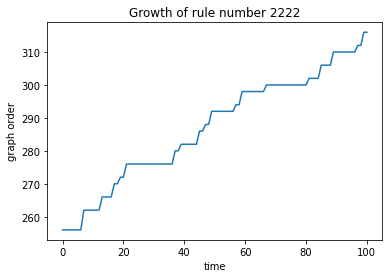

In [66]:
rule_number = 2222
time_max = 100

# initialize the list that will hold the succesive graph orders with the first value
growth = [graph.order()]

# loop that evolves the graph then adds the new graph order to the list
for i in range(time_max):
    graph.evolve(rule_number)
    growth.append(graph.order())

# growth plot
plt.plot(growth)
plt.title('Growth of rule number ' + str(rule_number))
plt.xlabel('time')
plt.ylabel('graph order')
plt.show()